In [70]:
import pickle
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

In [71]:
# Load the data
data_dir = '../data/cifar-10-batches-py'

def load_cifar_batch(batch_filename):
    with open(batch_filename, 'rb') as f:
        batch = pickle.load(f, encoding='latin1')
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = np.array(batch['labels'])
    return features, labels

x_train, y_train = [], []
for i in range(1, 6):
    features, labels = load_cifar_batch(os.path.join(data_dir, f'data_batch_{i}'))
    x_train.append(features)
    y_train.append(labels)

x_train = np.concatenate(x_train)
y_train = np.concatenate(y_train)

x_test, y_test = load_cifar_batch(os.path.join(data_dir, 'test_batch'))

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

In [72]:
# define CNN model
model = models.Sequential([
    layers.Input(shape=(32, 32, 3)),
    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(10)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

In [73]:
# Train with labeled data
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.3484 - loss: 1.8576 - val_accuracy: 0.4998 - val_loss: 1.4738
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.5435 - loss: 1.3913 - val_accuracy: 0.5771 - val_loss: 1.3129
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.6080 - loss: 1.2479 - val_accuracy: 0.6316 - val_loss: 1.1981
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.6503 - loss: 1.1459 - val_accuracy: 0.6554 - val_loss: 1.1350
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.6729 - loss: 1.1021 - val_accuracy: 0.6600 - val_loss: 1.1326
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.6862 - loss: 1.0666 - val_accuracy: 0.6652 - val_loss: 1.1269
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.6984 - loss: 1.0357 - val_accuracy: 0.6677 - val_loss: 1.1302
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.7056 - loss: 1

In [74]:
def generate_pseudo_labels(model, data):
    pseudo_labels = model.predict(data)
    pseudo_labels = tf.argmax(pseudo_labels, axis=1)
    return pseudo_labels.numpy()

In [75]:
# Using part of the test set as unlabeled data
unlabled_data = x_test[:5000]

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

datagen.fit(x_train)

# Apply data augmentation to the training data
augmented_data_iter = datagen.flow(x_train, batch_size=len(x_train), shuffle=False)
augmented_data = next(augmented_data_iter)[0]
augmented_data = augmented_data.astype(np.float32)

if len(augmented_data.shape) < 4:
    augmented_data = np.expand_dims(augmented_data, axis=0)

# Generate pseudo labels
pseudo_labels = generate_pseudo_labels(model, unlabled_data)

# Generate pseudo labels for augmented data
pseudo_labels_augmented = generate_pseudo_labels(model, augmented_data)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [76]:
# Combine the labeled and pseudo labeled data
combined_x = np.concatenate((x_train, unlabled_data, augmented_data))
combined_y = np.concatenate((y_train, pseudo_labels, pseudo_labels_augmented))

In [77]:
# Shuffle combined data
shuffled_indices = np.random.permutation(len(combined_x))
combined_x = combined_x[shuffled_indices]
combined_y = combined_y[shuffled_indices]

In [78]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [79]:
# Continue training with combined data
history_combined = model.fit(datagen.flow(combined_x, combined_y, batch_size=64), epochs=50, validation_data=(x_test, y_test))

Epoch 1/50
  4/860 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.6364 - loss: 1.2052 

/Users/stahlma/Desktop/Studium/Deep_Learning/Code/ssl-examples/myenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


860/860 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.6830 - loss: 1.0944 - val_accuracy: 0.6833 - val_loss: 1.1227
Epoch 2/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.6920 - loss: 1.0549 - val_accuracy: 0.7058 - val_loss: 1.0238
Epoch 3/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.6893 - loss: 1.0588 - val_accuracy: 0.7147 - val_loss: 1.0080
Epoch 4/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.6922 - loss: 1.0482 - val_accuracy: 0.7164 - val_loss: 1.0006
Epoch 5/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.6926 - loss: 1.0546 - val_accuracy: 0.7220 - val_loss: 0.9813
Epoch 6/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.7012 - loss: 1.0322 - val_accuracy: 0.6898 - val_loss: 1.0901
Epoch 7/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.6991 - loss: 1.0316 - val_accuracy: 0.7075 - val_loss: 1.0198
Epoch 8/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.7047 - loss: 1.0152 - val_accurac

In [80]:
# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f'Accuracy on the test set: {test_acc * 100:.2f}')

313/313 - 1s - 3ms/step - accuracy: 0.7621 - loss: 0.8644
Accuracy on the test set: 76.21


### Thoughts
1. Overfitting on the training data -> Take some steps to prevent
    - L2 Regularization
    - Data Augmentation
    - MixUp? (Consistency Regularization)
    - Early stopping on performance loss?


- Initial      70.82(test)      90(train)          -> Overfitting
- L2           72.32(test)      76.13(train)       -> Improved Overfitting
- L2 + DA      69.04(test)      0.72(train)        -> predictions get worse
- DA tuning    72.94(test)      72.75(train)       -> with tuned params this is the best result yet
- smaller lr   64.89(test)      62.18(train)       -> converges to slow

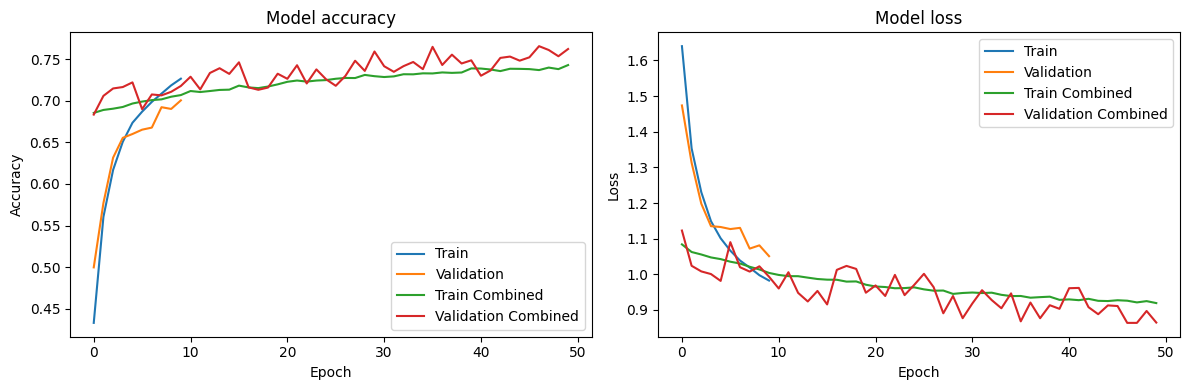

In [82]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history_combined.history['accuracy'])
plt.plot(history_combined.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation', 'Train Combined', 'Validation Combined'], loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history_combined.history['loss'])
plt.plot(history_combined.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation', 'Train Combined', 'Validation Combined'], loc='upper right')

plt.tight_layout()
plt.show()